# Intro
---
To preface, I am not strong at stats. This is a work in progress. Any feedback would be much appreciated.

This notebook is to test a claim made by some chief trader from this article: https://investorplace.com/smartmoney/2025/10/the-great-silver-shortage-why-prices-are-poised-to-break-out-again/


He states that given the **silver-gold ratio (SGR)** is *less than ($<$) 1.3%*, silver prices are poised to increase. My hypothesis is that this is not correct. We will use the price of gold and silver futures for the ratio then use it to predict future temporal prices. We must also acknowledge that the data are time series. So what is the best model and test for this case?

First we will analyze average return for when the signal is active (when SGR is $<1.3\%$) compared to when it's not (when SGR is $\geq1.3\%$). We are looking for returns when the signal is activated. 

In [96]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.api import VAR
from scipy import stats
import matplotlib.pyplot as plt
import os

In [97]:
def clean_existing_csvs():
    '''This cleans up the indeces of CSV. My local CSVs were disorganized'''
    base_dir = os.getcwd()
    folder_path = os.path.join(base_dir, "data")
    if not os.path.exists(folder_path):
        return
    for f in os.listdir(folder_path):
        if f.endswith(".csv"):
            path = os.path.join(folder_path, f)
            # Read while skipping junk header rows
            df = pd.read_csv(path, skiprows=[1,2], index_col=0)
            # Flatten multiindex if any
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = ['_'.join(col).strip() for col in df.columns.values]
            # Drop NaN rows created by the "Date" line
            df = df[df.index.notna()]
            # Overwrite cleaned file
            df.to_csv(path, index=True)
            print(f"Cleaned {f}")
            
def fetch_data(symbol):
    '''Get local data. If it does not exist, pull from yfinance'''
    base_dir = os.getcwd()
    folder_path = os.path.join(base_dir, "data")
    os.makedirs(folder_path, exist_ok=True)
    cache_file = f"{symbol.replace('=','-')}.csv"
    file_path = os.path.join(folder_path, cache_file)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        print(f"Loaded cached data for {symbol}")
    else:
        df = yf.download(symbol, start='1990-01-01', auto_adjust=True)[['Open', 'Close']]
        df.to_csv(file_path)
        print(f"Downloaded and cached data for {symbol}")
        
    # rename columns to prevent duplicates after concat
    df.columns = [f"{symbol}_Open", f"{symbol}_Close"]
    return df

In [98]:
clean_existing_csvs()

Cleaned GC-F.csv
Cleaned GLD.csv
Cleaned test_ticker.csv
Cleaned SLV.csv
Cleaned SI-F.csv


In [99]:
# Fetch data from Yahoo and only take the closing prices to model
silver = fetch_data('SI=F')
gold = fetch_data('GC=F')

df = pd.concat([silver, gold], axis=1, join='inner')

df = df.drop(df.filter(regex='_Open$').columns, axis=1)
df.head()

Loaded cached data for SI=F
Loaded cached data for GC=F


,SI=F_Close,GC=F_Close
Price,,
2000-09-01,5.004,277.000000
2000-09-05,4.998,275.799988
2000-09-06,4.983,274.200012
2000-09-07,4.935,274.000000
2000-09-08,4.923,273.299988


In [100]:
# Create SGR column
df['SGR'] = df['SI=F_Close'] / df['GC=F_Close']
df.head()

,SI=F_Close,GC=F_Close,SGR
Price,,,
2000-09-01,5.004,277.000000,0.018065
2000-09-05,4.998,275.799988,0.018122
2000-09-06,4.983,274.200012,0.018173
2000-09-07,4.935,274.000000,0.018011
2000-09-08,4.923,273.299988,0.018013


In [101]:
# We will define the signal to be 0 when disabled and 1 when active
df['signal'] = (df['SGR'] < 0.013).astype(int)
df['return_next'] = df['SI=F_Close'].pct_change().shift(-1)
df = df.dropna()
df.head()

,SI=F_Close,GC=F_Close,SGR,signal,return_next
Price,,,,,
2000-09-01,5.004,277.000000,0.018065,0,-0.001199
2000-09-05,4.998,275.799988,0.018122,0,-0.003001
2000-09-06,4.983,274.200012,0.018173,0,-0.009633
2000-09-07,4.935,274.000000,0.018011,0,-0.002432
2000-09-08,4.923,273.299988,0.018013,0,-0.007719


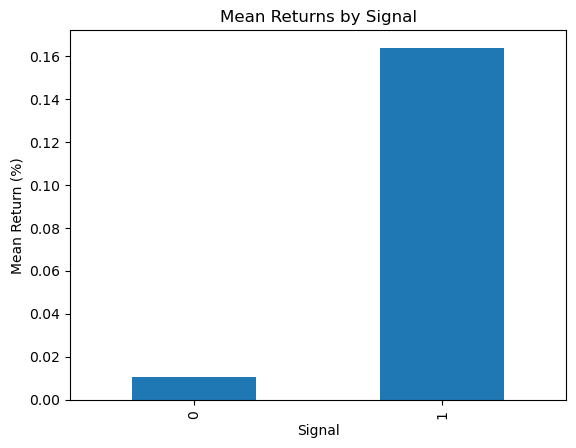

mean 0: 0.011 
mean 1: 0.164


In [102]:
signal_group = df.groupby('signal')['return_next']

means = signal_group.mean() * 100
vars_ = signal_group.var()

mean_0, mean_1 = round(means.loc[0], 3), round(means.loc[1], 3)
var_0, var_1 = vars_.loc[0], vars_.loc[1]

# Optional: visualize mean returns by signal
means.plot(kind='bar', title='Mean Returns by Signal')
plt.xlabel("Signal")
plt.ylabel("Mean Return (%)")
plt.show()
print(f"mean 0: {mean_0} \nmean 1: {mean_1}")



The signal seems promising! Past data shows short term returns if you hold your posiitons through when the signal is active (assuming you bought at when the signal appeared)! So maybe the claim is right.

We can use a $t$-test to rigorously verify, but the data violates assumptions so it won't be telling.

In [103]:
# Drop the any date before the first occurence of SGR < 1.13% since it is just noise this case
df = df.loc[df.index >= '2003-02-04']
df.head()

,SI=F_Close,GC=F_Close,SGR,signal,return_next
Price,,,,,
2003-02-04,4.911,379.000000,0.012958,1,-0.030544
2003-02-05,4.761,376.399994,0.012649,1,-0.018484
2003-02-06,4.673,370.100006,0.012626,1,-0.005778
2003-02-07,4.646,369.899994,0.012560,1,-0.010762
2003-02-10,4.596,363.700012,0.012637,1,-0.006527


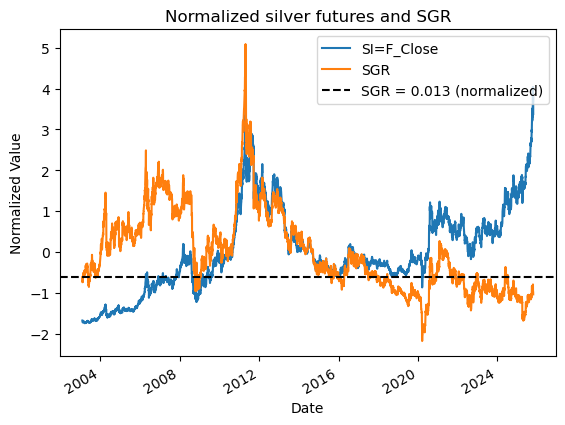

Correlation: 0.11394277504409482


In [104]:
# Now we check correlation and graph the time series
df_norm = (df - df.mean()) / df.std()
df_norm[['SI=F_Close', 'SGR']].plot(title='Normalized silver futures and SGR')
sgr_line = (0.013 - df['SGR'].mean()) / df['SGR'].std()
plt.axhline(y=sgr_line, color='black', linestyle='--', label='SGR = 0.013 (normalized)')

plt.xlabel("Date")
plt.ylabel("Normalized Value")


plt.legend()
plt.show()

print(f'Correlation: {df['SI=F_Close'].corr(df['SGR'])}')

What if we make the data stationary?

In [105]:
# Stationize the data
df['SI% change'] = df['SI=F_Close'].pct_change()
df['SGR% change'] = df['SGR'].pct_change()
df.head()

/var/folders/cx/gx6njnbj39qgss912bmvd5d40000gn/T/ipykernel_16714/3974465986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SI% change'] = df['SI=F_Close'].pct_change()
/var/folders/cx/gx6njnbj39qgss912bmvd5d40000gn/T/ipykernel_16714/3974465986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SGR% change'] = df['SGR'].pct_change()


,SI=F_Close,GC=F_Close,SGR,signal,return_next,SI% change,SGR% change
Price,,,,,,,
2003-02-04,4.911,379.000000,0.012958,1,-0.030544,NaN,NaN
2003-02-05,4.761,376.399994,0.012649,1,-0.018484,-0.030544,-0.023847
2003-02-06,4.673,370.100006,0.012626,1,-0.005778,-0.018484,-0.001776
2003-02-07,4.646,369.899994,0.012560,1,-0.010762,-0.005778,-0.005240
2003-02-10,4.596,363.700012,0.012637,1,-0.006527,-0.010762,0.006102


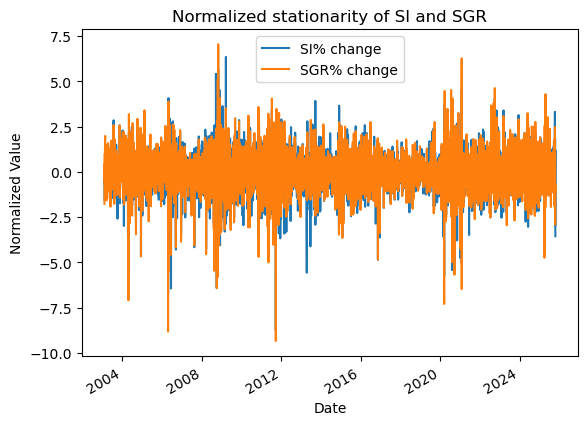

Correlation: 0.8597606734373562


In [106]:
# Now we check correlation and graph the time series
df_norm = (df - df.mean()) / df.std()
df_norm[['SI% change', 'SGR% change']].plot(title='Normalized stationarity of SI and SGR')

plt.xlabel("Date")
plt.ylabel("Normalized Value")


plt.legend()
plt.show()

print(f'Correlation: {df['SI% change'].corr(df['SGR% change'])}')

There we go! Highly correlated! This implies that SI moves with SGR, which makes sense since they are dependent on one another. In this case, SGR likely has no *predictive* power over SI since the heavy dependence and correlation. Just because it moves with it doesn't mean it can predict price. So how do we test predictive power?

In [107]:
# Build VAR model
df_stat = df[['SI% change', 'SGR% change']].iloc[1:]

model_var = VAR(df_stat)
results_var = model_var.fit(maxlags=7, ic='aic')  # Use AIC to select lag order
print(results_var.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 25, Oct, 2025
Time:                     16:55:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -17.7077
Nobs:                     5698.00    HQIC:                  -17.7275
Log likelihood:           34391.5    FPE:                1.97907e-08
AIC:                     -17.7381    Det(Omega_mle):     1.97007e-08
--------------------------------------------------------------------
Results for equation SI% change
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.000618         0.000272            2.275           0.023
L1.SI% change         -0.002272         0.026009           -0.087           0.930
L1.SGR% change        -0.033064         0.039072   

/opt/miniconda3/envs/tasty/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AI says short term predictive power is weak. Help me interpret this model!

I believe classical models and tests are not the best for this study, so next time I will implement modern models and test!